In [2]:
#!/usr/bin/env python3
import json
import psycopg2
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('../physrev.mpl')

import matplotlib.dates as mdates

# silence annoying warning about plotting pd.datetime objects with mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# connect to slow controls database

config = {
    "cage_daq":"10.66.193.71",
    "db_name":"cage_sc_db",
    "db_user": "cage_db_user",
    "password":"legend",
    "exchange":"alerts",
    "queue":"cage",
    "cage_rpi_ipa":"10.66.193.75",
    "cage_rpi_usr":"pi",
    "cage_rpi_pwd":"legendscanner",
    "newmark": "172.25.100.168"
}

db_conn = psycopg2.connect(dbname=config["db_name"], 
                           user=config["db_user"], 
                           password=config["password"], 
                           host=config["cage_daq"])
db_cursor = db_conn.cursor()

In [4]:
def pandas_db_query(endpoints, t_earlier, t_later, df_file=None):
    """
    general use function.
    for each endpoint and start/stop dates, create a DataFrame.
    if `df_file` is set, write the output to an HDF5 file.
    """
    dfs = {}

    for pt in endpoints:
        query = f"SELECT value_cal, timestamp FROM numeric_data "
        query += f"WHERE endpoint_name='{pt}'"
        query += f"AND timestamp>='{t_earlier}' and timestamp<='{t_later}';"
        
        db_cursor.execute(query)
        record = db_cursor.fetchall()
        df = pd.DataFrame(record, columns=[pt, 'timestamp']) 
        
        # convert to local (pacific) time
        df["time"] = df['timestamp'].dt.tz_localize('utc').dt.tz_convert('US/Pacific')

        # print(pt)
        # print(dfs[pt].head(10))
        
        dfs[pt] = df
        
        if df_file is not None:
            df.to_hdf(df_file, key=pt)
            
    return dfs

      cage_baseline                  timestamp   
1753        0.05350 2023-06-01 00:59:05.544519  \
1754        0.04825 2023-06-01 00:59:17.575753   
1755        0.07825 2023-06-01 00:59:29.393078   
1756        0.05200 2023-06-01 00:59:41.622217   
1757        0.07750 2023-06-01 00:59:54.042365   

                                 time  
1753 2023-05-31 17:59:05.544519-07:00  
1754 2023-05-31 17:59:17.575753-07:00  
1755 2023-05-31 17:59:29.393078-07:00  
1756 2023-05-31 17:59:41.622217-07:00  
1757 2023-05-31 17:59:54.042365-07:00  


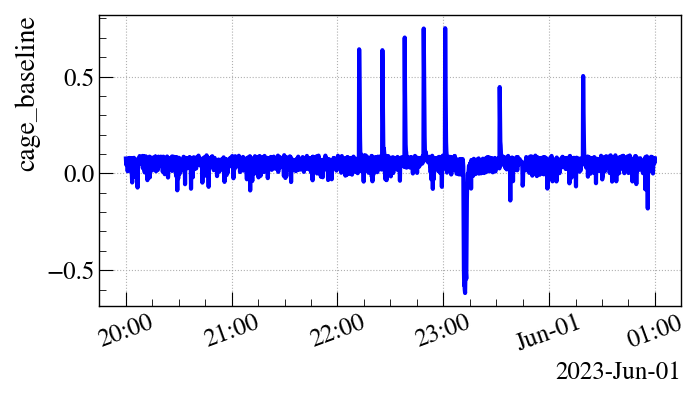

In [19]:
%matplotlib widget
fig = plt.figure(figsize=(7, 4))
fig.canvas.header_visible = False

epts = ["cage_baseline", "cage_hv_vmon"]
t_earlier = '2023-05-31T20:00'
t_later = '2023-06-01T01:00'

dfs = pandas_db_query(epts, t_earlier, t_later)
print(dfs[epts[0]].tail())

xv = dfs[epts[0]]["time"]
yv = dfs[epts[0]][epts[0]]

plt.plot(xv, yv, '-b')
plt.ylabel(epts[0], ha='right', y=1)
plt.tick_params(axis='x', rotation=20)

# this is fiddly
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%y/%m/%d %:%M"))

# ooh, the ConciseDateFormatter is really nice!
locator = mdates.AutoDateLocator(minticks=4, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

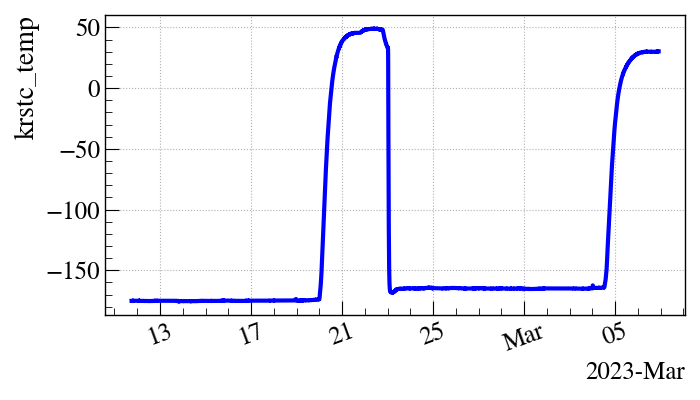

In [7]:
%matplotlib widget
fig = plt.figure(figsize=(7, 4))
fig.canvas.header_visible = False

epts = ['krstc_temp']
t_earlier = '2023-02-11T18:00'
t_later = '2023-03-10T00:00'

# t_earlier = '2023-03-11T18:00'
# t_later = '2023-03-15T00:00'

dfs = pandas_db_query(epts, t_earlier, t_later)

# example of a filter
df = dfs['krstc_temp'].query('krstc_temp < 900')

xv = df['time']
yv = df['krstc_temp']
plt.plot(xv, yv, '-b')
plt.ylabel(epts[0], ha='right', y=1)
plt.tick_params(axis='x', rotation=20)

locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [11]:
# download data from the "Kr Mystery (TM) period"
epts = ['krstc_baseline', 'krstc_temp', 'krstc_pressure', 'krstc_hv_vmon']

t_earlier = '2023-02-10T18:00'
t_later = '2023-03-10T00:00'

# t_earlier = '2023-03-11T18:00'
# t_later = '2023-03-15T00:00'

dfs = pandas_db_query(epts, t_earlier, t_later)

/Users/mjcenpa/Library/Python/3.9/lib/python/site-packages/ipympl/backend_nbagg.py:279: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 12.
  self.manager.handle_json(content)


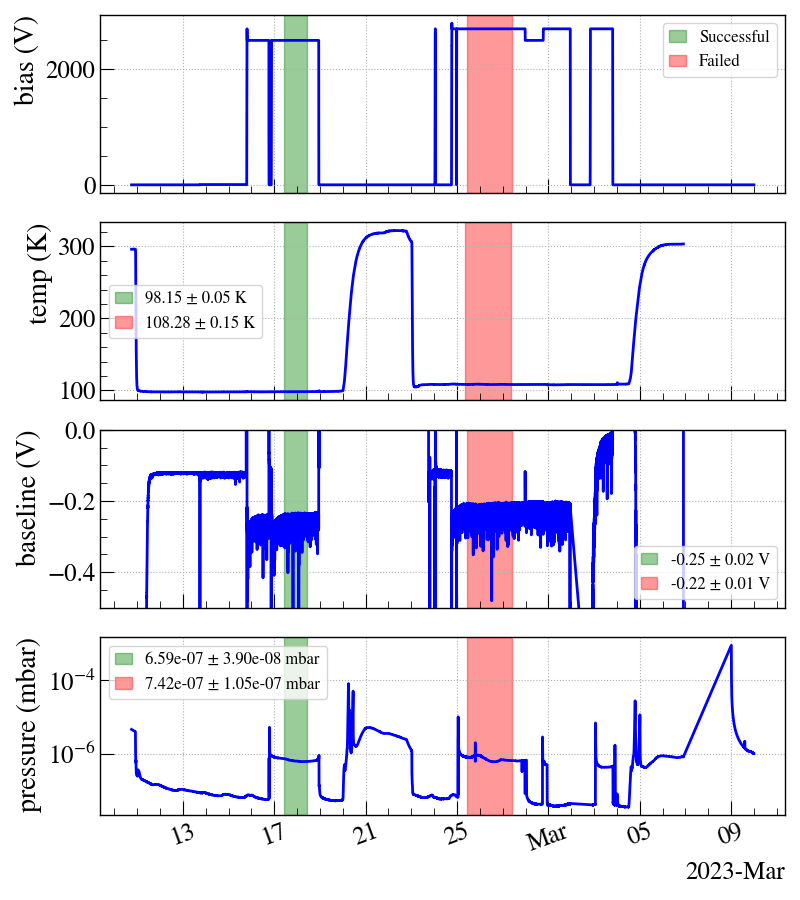

In [12]:
%matplotlib widget
# fig = plt.figure(figsize=(7, 4))
fig, p = plt.subplots(4, 1, figsize=(8,9), sharex=True)
fig.canvas.header_visible = False

# GMT times of interest
time1_lo, time1_hi = '2023-02-17T10:00:00', '2023-02-18T10:00:00'
time2_lo, time2_hi = '2023-02-25T10:00:00', '2023-02-27T10:00:00'

# 1. high voltage - find periods of constant bias
df_vmon = dfs['krstc_hv_vmon'].copy()

p[0].plot(df_vmon.time, df_vmon.krstc_hv_vmon, '-b', lw=2)

ix1lo = df_vmon.timestamp.searchsorted(time1_lo) # find closest to here
ix1hi = df_vmon.timestamp.searchsorted(time1_hi)
ix2lo = df_vmon.timestamp.searchsorted(time2_lo)
ix2hi = df_vmon.timestamp.searchsorted(time2_hi)

p[0].axvspan(df_vmon.time[ix1lo], df_vmon.time[ix1hi], 
             color='g', alpha=0.4, label='Successful')

p[0].axvspan(df_vmon.time[ix2lo], df_vmon.time[ix2hi], 
             color='r', alpha=0.4, label='Failed')

p[0].legend(fontsize=12)
p[0].set_ylabel('bias (V)', ha='right', y=1)

# 2. temperature
df_temp = dfs['krstc_temp'].copy()
df_temp = df_temp.query('krstc_temp < 900').copy()
df_temp['temp_K'] = df_temp['krstc_temp'] + 273.15

p[1].plot(df_temp.time, df_temp.temp_K, '-b', lw=2)

ix1lo = df_temp.timestamp.searchsorted(time1_lo)
ix1hi = df_temp.timestamp.searchsorted(time1_hi)
ix2lo = df_temp.timestamp.searchsorted(time2_lo)
ix2hi = df_temp.timestamp.searchsorted(time2_hi)

cooldown1_temp = df_temp[ix1lo:ix1hi].temp_K.mean()
cooldown1_temp_unc = df_temp[ix1lo:ix1hi].temp_K.std()
cooldown2_temp = df_temp[ix2lo:ix2hi].temp_K.mean()
cooldown2_temp_unc = df_temp[ix2lo:ix2hi].temp_K.std()

p[1].axvspan(df_temp.time[ix1lo], df_temp.time[ix1hi], 
             color='g', alpha=0.4, label=f'{cooldown1_temp:.2f} ± {cooldown1_temp_unc:.2f} K')

p[1].axvspan(df_temp.time[ix2lo], df_temp.time[ix2hi], 
             color='r', alpha=0.4, label=f'{cooldown2_temp:.2f} ± {cooldown2_temp_unc:.2f} K')

p[1].legend(fontsize=12)
p[1].set_ylabel('temp (K)', ha='right', y=1)
p[1].tick_params(axis='x', rotation=20)

# # 3. baseline
df_base = dfs['krstc_baseline'].copy()
# df_base = df_base.query('abs(krstc_baseline) < 1').copy()

p[2].plot(df_base.time, df_base.krstc_baseline, '-b', lw=2)

ix1lo = df_base.timestamp.searchsorted(time1_lo)
ix1hi = df_base.timestamp.searchsorted(time1_hi)
ix2lo = df_base.timestamp.searchsorted(time2_lo)
ix2hi = df_base.timestamp.searchsorted(time2_hi)
bl_avg1 = df_base[ix1lo:ix1hi].krstc_baseline.mean()
bl_avg1_unc = df_base[ix1lo:ix1hi].krstc_baseline.std()
bl_avg2 = df_base[ix2lo:ix2hi].krstc_baseline.mean()
bl_avg2_unc = df_base[ix2lo:ix2hi].krstc_baseline.std()

p[2].axvspan(df_base.time[ix1lo], df_base.time[ix1hi], 
             color='g', alpha=0.4, label=f'{bl_avg1:.2f} ± {bl_avg1_unc:.2f} V')

p[2].axvspan(df_base.time[ix2lo], df_base.time[ix2hi], 
             color='r', alpha=0.4, label=f'{bl_avg2:.2f} ± {bl_avg2_unc:.2f} V')

p[2].legend(loc=4, fontsize=12)
p[2].set_ylabel('baseline (V)', ha='right', y=1)
p[2].set_ylim(-0.5, 0)

# 4. pressure
df_press = dfs['krstc_pressure'].copy()
df_press = df_press.query('krstc_pressure < 1e-3 and krstc_pressure > 1e-9').copy()

p[3].semilogy(df_press.time, df_press.krstc_pressure, '-b', lw=2)

ix1lo = df_press.timestamp.searchsorted(time1_lo)
ix1hi = df_press.timestamp.searchsorted(time1_hi)
ix2lo = df_press.timestamp.searchsorted(time2_lo)
ix2hi = df_press.timestamp.searchsorted(time2_hi)
pr_avg1 = df_press[ix1lo:ix1hi].krstc_pressure.mean()
pr_avg1_unc = df_press[ix1lo:ix1hi].krstc_pressure.std()
pr_avg2 = df_press[ix2lo:ix2hi].krstc_pressure.mean()
pr_avg2_unc = df_press[ix2lo:ix2hi].krstc_pressure.std()

p[3].axvspan(df_press.time[ix1lo], df_press.time[ix1hi], 
             color='g', alpha=0.4, label=f'{pr_avg1:.2e} ± {pr_avg1_unc:.2e} mbar')

p[3].axvspan(df_press.time[ix2lo], df_press.time[ix2hi], 
             color='r', alpha=0.4, label=f'{pr_avg2:.2e} ± {pr_avg2_unc:.2e} mbar')


p[3].legend(fontsize=12)
p[3].set_ylabel('pressure (mbar)', ha='right', y=1)
p[3].tick_params(axis='x', rotation=20)
p[3].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
p[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

plt.tight_layout()
plt.show()

In [21]:
# 21 April 2023 - Campaign 9

epts = ['cage_baseline', 'cage_coldPlate_temp', 'cage_pressure', 'cage_hv_vmon', 'cage_ln_level']

t_earlier = '2023-05-31T20:00'
t_later = '2023-06-01T01:00'

dfs = pandas_db_query(epts, t_earlier, t_later)

In [52]:
print(df_base.time.iloc[700])
print(df_base.cage_baseline[:700].mean())
print(df_base.cage_baseline[:700].std())

2023-05-31 14:58:45.898115-07:00
0.05185214285714298
0.029901296778729648


In [51]:
print(df_base.time.iloc[-200])
print(df_base.cage_baseline[-200:].mean())
print(df_base.cage_baseline[-200:].std())

2023-05-31 17:25:14.041208-07:00
0.04688875000000014
0.0359225830194804


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


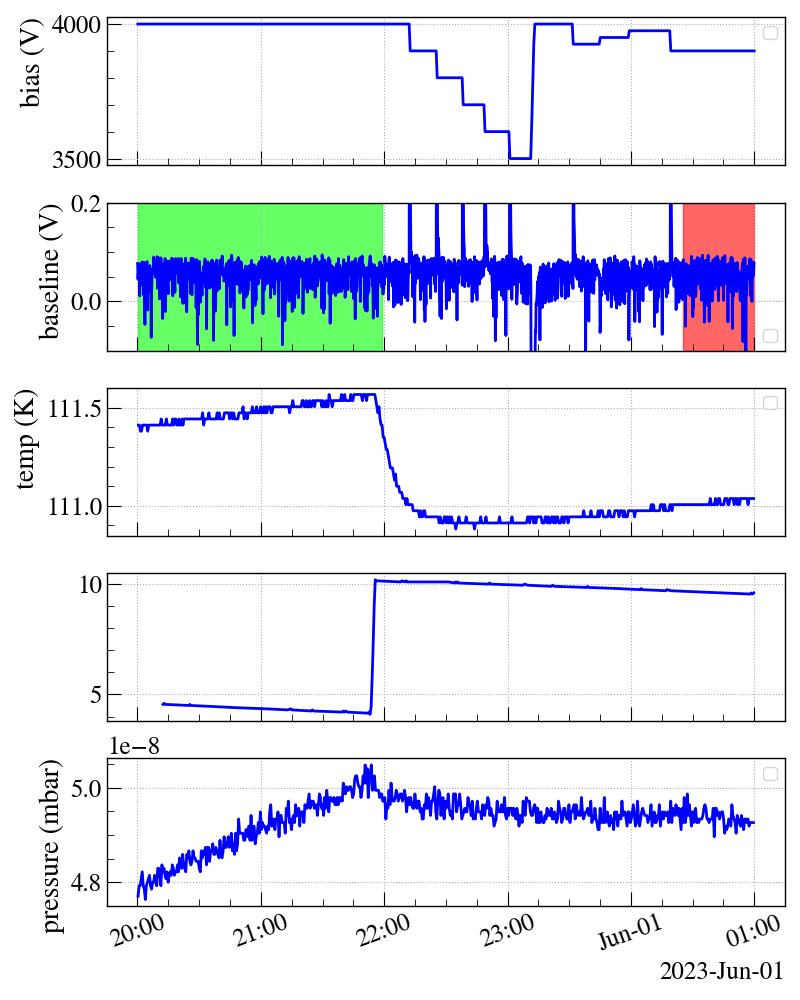

In [49]:
%matplotlib widget
# fig = plt.figure(figsize=(7, 4))
fig, p = plt.subplots(5, 1, figsize=(8,10), sharex=True)
fig.canvas.header_visible = False

# 1. high voltage - find periods of constant bias
df_vmon = dfs['cage_hv_vmon'].copy()

p[0].plot(df_vmon.time, df_vmon.cage_hv_vmon, '-b', lw=2)
p[0].legend(fontsize=12)
p[0].set_ylabel('bias (V)', ha='right', y=1)



# 2. baseline
df_base = dfs['cage_baseline'].copy()
# df_base = df_base.query('abs(krstc_baseline) < 1').copy()

# p[1].plot(df_base.time[::5], df_base.cage_baseline.rolling(5).mean()[::5], '-b', lw=2) # average every 5 baseline readings
p[1].plot(df_base.time, df_base.cage_baseline, '-b', lw=2)
p[1].legend(loc=4, fontsize=12)
p[1].set_ylabel('baseline (V)', ha='right', y=1)
p[1].set_ylim(-0.1, 0.2)
p[1].axvspan(df_base.time.iloc[0], df_base.time.iloc[700], color='lime', alpha=0.6)
p[1].axvspan(df_base.time.iloc[-200], df_base.time.iloc[-1], color='red', alpha=0.6)


# 3. temperature
df_temp = dfs['cage_coldPlate_temp'].copy()
#df_temp = df_temp.query('krstc_temp < 900').copy()
df_temp['temp_K'] = df_temp['cage_coldPlate_temp'] + 273.15

p[2].plot(df_temp.time, df_temp.temp_K, '-b', lw=2)
p[2].legend(fontsize=12)
p[2].set_ylabel('temp (K)', ha='right', y=1)
p[2].tick_params(axis='x', rotation=20)

# 4. ln level
df_lnlevel = dfs['cage_ln_level'].copy()
p[3].plot(df_lnlevel.time, df_lnlevel.cage_ln_level, '-b', lw=2)



# 5. pressure
df_press = dfs['cage_pressure'].copy()
# df_press = df_press.query('krstc_pressure < 1e-3 and krstc_pressure > 1e-9').copy()
p[4].plot(df_press.time, df_press.cage_pressure, '-b', lw=2)
p[4].legend(fontsize=12)
p[4].set_ylabel('pressure (mbar)', ha='right', y=1)
p[4].tick_params(axis='x', rotation=20)
p[4].xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
p[4].xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))



plt.tight_layout()
plt.show()